In [55]:
import os
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from datetime import datetime, timedelta, date
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from utils import normalize_image, get_sequences, plot_image, plot_images
from dust_analysis import (left_pass_pairs, right_pass_pairs, read_raw_image, read_rectified_image, 
    print_seg_performance, print_seg_dust_performance, get_seg_dust_performance_by_time, get_seg_dust_performance_by_camera_pod)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analyze the vehicle in dust datasets (two datasets: labeled and full unlabeled)

In [36]:
data_root_dir = '/data/jupiter/datasets'
# data_root_dir = '/data2/jupiter/datasets'
unlabeled_datasets = [
    "halo_vehicles_driving_through_dust_images_nodust_reserved_stereo", 
    "halo_human_in_dust_day_collection_may29",
]
labeled_datasets = [
    "halo_vehicles_driving_through_dust_images_nodust_reserved_labeled", 
    "halo_human_in_dust_day_collection_may29_human_labeled_stereo",
]
pred_root_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
models = [
    # '20676_r2_rgb_bigdecay_biglr',
    # 'v81_nextvitsmall_dust_only_kore_dean_0406',
    # 'v81_80k_maxfov_iwtv_kore_0423_v81_dust_0430',
    'v81_80k_maxfov_wn_ft_kore_0430_v81_dust_0501',
    'all_rev2_rev1_lying_down_sitting_headlights_round_2_25_ep_prod_weights_10_lo_10_tr_dust_0601',
    # 'all_rev2_rev1_lying_down_sitting_headlights_round_2_25_ep_prod_weights_dust_0601',
]
di = 1
suffix = ''
# suffix = '_maxfov_alleysson_depth0423'

In [23]:
raw_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[di]+suffix, 'master_annotations.csv'))
raw_df['camera_pair'] = raw_df.unique_id.apply(lambda s: s[-7:])
stereo_df = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[di]+suffix, 'master_annotations.csv'))
stereo_df['camera_pair'] = stereo_df.unique_id.apply(lambda s: s[-7:])
print(raw_df.shape, stereo_df.shape)

(35854, 153) (5968, 278)


/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
def read_csvs(pred_root_dir, model, labeled_dataset):
    pred_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'output.csv'))
    if not 'state' in pred_df:
        pred_df['state'] = pred_df['result_state']
    dust_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'dust_ratio.csv'))
    print(pred_df.shape, dust_df.shape)
    return pred_df, dust_df

In [37]:
# load pred and dust df
pred_df1, dust_df1 = read_csvs(pred_root_dir, models[0], labeled_datasets[di]+suffix)
pred_df2, dust_df2 = read_csvs(pred_root_dir, models[1], labeled_datasets[di]+suffix)
# compare performance
print_seg_dust_performance(pred_df1, dust_df1, model_desc='model 1')
print_seg_dust_performance(pred_df2, dust_df2, model_desc='model 2')

(5968, 16) (5968, 7)
(5968, 16) (5968, 7)
model 1: TP 4083, TN 1753, FP 35, FN 97, Recall 0.9768, Productivity 0.9804
model 1 dust: TP 0.04, TN 0.05, FP 0.05, FN 0.20
model 2: TP 4166, TN 1737, FP 51, FN 14, Recall 0.9967, Productivity 0.9715
model 2 dust: TP 0.07, TN 0.07, FP 0.06, FN 0.28


In [21]:
# get performance by operation time
get_seg_dust_performance_by_time(raw_df, pred_df1, dust_df1, model_desc='model 1')
get_seg_dust_performance_by_time(raw_df, pred_df2, dust_df2, model_desc='model 2')

(1932, 152) (2832, 152)
model 1 day: TP 968, TN 907, FP 5, FN 52, Recall 0.9490, Productivity 0.9945
model 1 day dust: TP 0.13, TN 0.08, FP 0.11, FN 0.21
model 1 night: TP 1568, TN 890, FP 1, FN 373, Recall 0.8078, Productivity 0.9989
model 1 night dust: TP 0.16, TN 0.20, FP 0.07, FN 0.27
(1932, 152) (2832, 152)
model 2 day: TP 968, TN 907, FP 5, FN 52, Recall 0.9490, Productivity 0.9945
model 2 day dust: TP 0.13, TN 0.08, FP 0.11, FN 0.21
model 2 night: TP 1568, TN 890, FP 1, FN 373, Recall 0.8078, Productivity 0.9989
model 2 night dust: TP 0.16, TN 0.20, FP 0.07, FN 0.27


In [56]:
# get performance by camera pod
camera_pods = {'front': ['T01', 'T02', 'T03', 'T04'], 'right': ['T05', 'T06', 'T07', 'T08'], 'back': ['T09', 'T10', 'T11', 'T12'], 'left': ['T13', 'T14', 'T15', 'T16']}
get_seg_dust_performance_by_camera_pod(raw_df, pred_df1, dust_df1, model_desc='model 1', camera_pods=camera_pods)
get_seg_dust_performance_by_camera_pod(raw_df, pred_df2, dust_df2, model_desc='model 2', camera_pods=camera_pods)

front (646, 166)
model 1 front: TP 439, TN 168, FP 4, FN 35, Recall 0.9262, Productivity 0.9767
model 1 front dust: TP 0.04, TN 0.04, FP 0.02, FN 0.11
right (1357, 166)
model 1 right: TP 1074, TN 269, FP 7, FN 7, Recall 0.9935, Productivity 0.9746
model 1 right dust: TP 0.02, TN 0.01, FP 0.02, FN 0.15
back (2171, 166)
model 1 back: TP 1349, TN 818, FP 2, FN 2, Recall 0.9985, Productivity 0.9976
model 1 back dust: TP 0.02, TN 0.01, FP 0.07, FN 0.09
left (1796, 166)
model 1 left: TP 1221, TN 500, FP 22, FN 53, Recall 0.9584, Productivity 0.9579
model 1 left dust: TP 0.10, TN 0.12, FP 0.07, FN 0.26
front (646, 166)
model 2 front: TP 470, TN 165, FP 7, FN 4, Recall 0.9916, Productivity 0.9593
model 2 front dust: TP 0.08, TN 0.05, FP 0.02, FN 0.19
right (1357, 166)
model 2 right: TP 1079, TN 268, FP 8, FN 2, Recall 0.9981, Productivity 0.9710
model 2 right dust: TP 0.04, TN 0.03, FP 0.04, FN 0.40
back (2171, 166)
model 2 back: TP 1348, TN 810, FP 10, FN 3, Recall 0.9978, Productivity 0.9878

In [54]:
pred_df2.head(2)

,unique_id,id,camera_location,operation_time,special_notes,jdb_s3_path,result_state,result_human_state,result_vehicle_state,min_pixels_threshold,features,n_gt_human_pixels,gt_human_depth,n_pred_human_pixels,pred_human_depth,state
0,66595e558b545d525752cfb2_T02_T03,66595e558b545d525752cfb2,T02,daytime,front left center human in dust,NaN,true_positive,true_positive,NaN,67,"{""large_object_pixels"": 32, ""large_object_min_...",1693,0.11258,1610,0.11258,true_positive
1,66595eea568146714ce37514_T02_T03,66595eea568146714ce37514,T02,daytime,front left center human in dust,NaN,true_positive,true_positive,NaN,67,"{""large_object_pixels"": 32, ""large_object_min_...",2046,0.12735,1993,0.12735,true_positive


In [34]:
seq_dfs = get_sequences(stereo_df, interval=60, per_camera=False)
print(len(seq_dfs))

15


In [35]:
for seq_df in seq_dfs:
    print(seq_df.camera_pair.unique())

['T02_T03' 'T02_T04']
['T02_T03' 'T02_T04']
['T02_T03' 'T02_T04']
['T02_T03' 'T02_T04']
['T13_T15' 'T14_T15' 'T14_T16']
['T14_T15' 'T14_T16' 'T13_T15']
['T14_T15' 'T14_T16']
['T10_T12' 'T09_T11' 'T10_T11']
['T10_T11' 'T10_T12']
['T10_T12' 'T10_T11']
['T10_T11' 'T10_T12']
['T06_T07' 'T06_T08' 'T05_T07']
['T06_T07' 'T06_T08' 'T05_T07']
['T06_T07' 'T06_T08']
['T01_T03' 'T02_T03' 'T02_T04']


In [28]:
def get_text(raw_row, pred_df, dust_df, model_desc):
    s = ''
    c = (255,0,0)
    pred_rows = pred_df[pred_df.unique_id == raw_row.unique_id]
    if len(pred_rows) > 0:
        state = pred_rows.iloc[0].state
        if state == 'true_positive' or state == 'true_negative':
            c = (0,255,0)
        s += f'{model_desc} state: {state}'
    dust_rows = dust_df[dust_df.unique_id == raw_row.unique_id]
    if len(dust_rows) > 0:
        s += f' dust: {dust_rows.iloc[0].total_averaged_dust_conf*100:.2f}%'
    return s, c

def add_text2(frame, raw_row, pred_df1, dust_df1, pred_df2, dust_df2, model_desc1, model_desc2):
    frame = cv2.putText(frame, f'{raw_row.camera_pair}, {raw_row.collected_on}', 
                        (10,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    s1, c1 = get_text(raw_row, pred_df1, dust_df1, model_desc1)
    if s1:
        frame = cv2.putText(frame, s1, 
                            (10,65), cv2.FONT_HERSHEY_SIMPLEX, 1, c1, 2, cv2.LINE_AA)
    s2, c2 = get_text(raw_row, pred_df2, dust_df2, model_desc2)
    if s2:
        frame = cv2.putText(frame, s2, 
                            (10,105), cv2.FONT_HERSHEY_SIMPLEX, 1, c2, 2, cv2.LINE_AA)
    return frame

In [51]:
def create_video_from_rectified_rgb2(seq_dfs, si, raw_df, pred_root_dir, model, labeled_datasets, di, data_root_dir, unlabeled_datasets, 
                                    pred_df1, dust_df1, pred_df2, dust_df2, model_desc1, model_desc2, show_in_left_right_pass=True):
    seq_df = seq_dfs[si]

    # get raw sequence
    start, end = seq_df.iloc[0].collected_on, seq_df.iloc[-1].collected_on
    seq_raw_df = raw_df[(raw_df.collected_on >= start) & (raw_df.collected_on <= end)]
    print(f'process {si}th sequence', seq_df.shape, seq_raw_df.shape)

    # compare model performance
    sub_pred_df1 = pred_df1[pred_df1.unique_id.isin(seq_df.unique_id)]
    sub_pred_df2 = pred_df2[pred_df2.unique_id.isin(seq_df.unique_id)]
    print_seg_performance(sub_pred_df1, model_desc1)
    print_seg_performance(sub_pred_df2, model_desc2)

    # get pair-wise cameras
    cameras = list(seq_df.camera_location.unique())
    cameras.sort()
    camera_pairs = list(seq_df.camera_pair.unique())
    camera_pairs.sort()
    print(cameras, camera_pairs)

    # check if should use left pass or right pass or both
    pass_key = ''
    if show_in_left_right_pass:
        in_left = set(camera_pairs).intersection(left_pass_pairs)
        in_right = set(camera_pairs).intersection(right_pass_pairs)
        # print(len(in_left), len(in_right))
        if len(in_left) > len(in_right):
            camera_pairs = left_pass_pairs
            pass_key = 'left_pass'
        elif len(in_left) < len(in_right):
            camera_pairs = right_pass_pairs
            pass_key = 'right_pass'
        else:
            pass_key = 'short_pass'

    # get per-camera dfs and truncate to same length
    camera_dfs = [seq_raw_df[seq_raw_df.unique_id.str.endswith(c)] for c in camera_pairs]
    camera_dfs = [cdf.sort_values('collected_on', ignore_index=True) for cdf in camera_dfs]
    print([len(cdf) for cdf in camera_dfs])
    min_len = min(len(cdf) for cdf in camera_dfs)
    camera_dfs = [cdf.iloc[:min_len] for cdf in camera_dfs]

    # create video
    video_dir = os.path.join(pred_root_dir, model, labeled_datasets[di], 'videos')
    os.makedirs(video_dir, exist_ok=True)
    video_name = os.path.join(video_dir, f'{start}_{pass_key}_{si}.mp4')
    image_rows = 1  # number of rows to display image
    image_cols = math.ceil(len(camera_dfs)/image_rows)
    height, width = 512, 768
    # print(width*2,height*math.ceil(len(camera_dfs)/2))

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 3, (width*image_cols,height*image_rows), isColor=True)
    for fi in range(min_len):
        frames = []
        for pair_i in range(image_rows):
            pair_frame = []
            for _fi in range(image_cols):
                if pair_i*image_cols+_fi == len(camera_dfs):
                    frame = np.zeros((512, 768, 3), dtype=np.uint8)
                else:
                    frame = read_rectified_image(data_root_dir, unlabeled_datasets[di], camera_dfs[pair_i*image_cols+_fi].iloc[fi])
                    if frame.shape[1] != 768:
                        zeros = np.zeros((512, 768, 3), dtype=frame.dtype)
                        zeros[:,:frame.shape[1],:] = frame
                        frame = zeros
                    frame = add_text2(frame, camera_dfs[pair_i*image_cols+_fi].iloc[fi], pred_df1, dust_df1, pred_df2, dust_df2, model_desc1, model_desc2)
                pair_frame.append(frame)
            pair_frame = np.concatenate(pair_frame, axis=1)
            frames.append(pair_frame)
        frame = np.concatenate(frames, axis=0)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video.write(frame)
    # cv2.destroyAllWindows()
    video.release()

for si in range(len(seq_dfs)):
    # si = 6
    # create_video_from_rectified_rgb(seq_dfs, si, raw_df, pred_root_dir, model, labeled_datasets, di, data_root_dir, unlabeled_datasets, pred_df, dust_df)
    create_video_from_rectified_rgb2(seq_dfs, si, raw_df, pred_root_dir, models[1], labeled_datasets, di, data_root_dir, unlabeled_datasets, 
                                    pred_df1, dust_df1, pred_df2, dust_df2, model_desc1='deployed', model_desc2='to deploy', show_in_left_right_pass=False)
    # break

process 0th sequence (246, 279) (990, 153)
deployed: TP 113, TN 128, FP 3, FN 2, Recall 0.9826, Productivity 0.9771
to deploy: TP 114, TN 126, FP 5, FN 1, Recall 0.9913, Productivity 0.9618
['T02'] ['T02_T03', 'T02_T04']
[149, 148]
process 1th sequence (74, 279) (327, 153)
deployed: TP 35, TN 36, FP 1, FN 2, Recall 0.9459, Productivity 0.9730
to deploy: TP 37, TN 36, FP 1, FN 0, Recall 1.0000, Productivity 0.9730
['T02'] ['T02_T03', 'T02_T04']
[55, 55]
process 2th sequence (16, 279) (90, 153)
deployed: TP 13, TN 3, FP 0, FN 0, Recall 1.0000, Productivity 1.0000
to deploy: TP 13, TN 2, FP 1, FN 0, Recall 1.0000, Productivity 0.6667
['T02'] ['T02_T03', 'T02_T04']
[8, 8]
process 3th sequence (26, 279) (312, 153)
deployed: TP 22, TN 0, FP 0, FN 4, Recall 0.8462, Productivity 0.0000
to deploy: TP 26, TN 0, FP 0, FN 0, Recall 1.0000, Productivity 0.0000
['T02'] ['T02_T03', 'T02_T04']
[26, 26]
process 4th sequence (806, 279) (3384, 153)
deployed: TP 513, TN 252, FP 22, FN 19, Recall 0.9643, P

## Check performance on standalone dataset

In [2]:
# root_dir = '/data/jupiter/li.yu/data'
root_dir = '/data/jupiter/datasets/'
# root_dir = '/data2/jupiter/datasets/'
# root_dir = '/data2/jupiter/datasets/rev1_ask_ben_cline_before_deleting'
dataset = 'halo_failure_case_of_box_in_dust'
# dataset = 'humans_on_path_test_set_2023_v15_anno'
# dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_labeled'
# csv = os.path.join(root_dir, dataset, 'master_annotations_mhc.csv')
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
df = pd.read_csv(csv, converters=converters)
df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2,105) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(55795, 150)

In [13]:
def read_csvs(pred_root_dir, model, labeled_dataset):
    pred_df = pd.DataFrame()
    if os.path.isfile(os.path.join(pred_root_dir, model, labeled_dataset, 'output.csv')):
        pred_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'output.csv'))
        if not 'state' in pred_df:
            pred_df['state'] = pred_df['result_state']
    dust_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'dust_ratio.csv'))
    print(pred_df.shape, dust_df.shape)
    return pred_df, dust_df

In [49]:
pred_root_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
# model = 'v511rd_7cls_ft_dustaugonhuman_0908_v481_dusthead_0917'
# model = '20676_r2_rgb_bigdecay_biglr'
# model = 'v81_80k_maxfov_iwtv_kore_0423_v81_dust_0430'
# model = 'v81_80k_maxfov_wn_ft_kore_0430_v81_dust_0501'
model = 'ds_v8_1_nextvit_small_openimages_using_random_val_50k_rev1_rev2_lying_down_sitting_2x_lower_airborne_birds_lower_msl_d_2h_v81_dust_0517'

# load pred and dust df
pred_df, dust_df = read_csvs(pred_root_dir, model, dataset)

(55793, 16) (55793, 7)


In [5]:
pred_df.head(2)

,unique_id,id,camera_location,operation_time,special_notes,jdb_s3_path,result_state,result_human_state,result_vehicle_state,min_pixels_threshold,features,n_gt_human_pixels,gt_human_depth,n_pred_human_pixels,pred_human_depth,state
0,66312df2a9217d4c75fcb245_T02_T03,66312df2a9217d4c75fcb245,T02,daytime,NaN,NaN,false_positive,NaN,true_negative,67,"{""large_object_pixels"": 752, ""large_object_min...",0,1000,0,1000,false_positive
1,66312e3c22aa441a4b2ff40e_T02_T03,66312e3c22aa441a4b2ff40e,T02,daytime,NaN,NaN,true_negative,NaN,true_negative,67,"{""large_object_pixels"": 96, ""large_object_min_...",0,1000,0,1000,true_negative


In [33]:
dust_df.head(2)

,id,camera_location,operation_time,state,additional_state,instance_states,instance_additional_states,num_instances,min_pixels_threshold,gt_dust_label,pred_dust_ratio
0,66312dea5bd1d0e42a69426a,T01,daytime,true_negative,start,NaN,NaN,NaN,NaN,0.0,0.0
1,66312e0fa9217d4c75fcb2d9,T01,daytime,true_negative,start,NaN,NaN,NaN,NaN,0.0,0.0


In [50]:
print(pred_df[pred_df.result_state == 'false_positive'].shape, dust_df[dust_df.total_averaged_dust_conf > 0.1].shape)
dust_df.total_averaged_dust_conf.describe()
# print(dust_df[dust_df.pred_dust_ratio > 10].shape)
# dust_df.pred_dust_ratio.describe()

(5353, 16) (0, 7)


count    5.579300e+04
mean     7.345950e-05
std      1.104634e-04
min      7.231472e-07
25%      1.947524e-05
50%      4.354928e-05
75%      8.321564e-05
max      3.129047e-03
Name: total_averaged_dust_conf, dtype: float64

## Study dust on lens problem

In [29]:
# root_dir = '/data/jupiter/li.yu/data'
root_dir = '/data/jupiter/datasets/'
# root_dir = '/data2/jupiter/datasets/'
# root_dir = '/data2/jupiter/datasets/rev1_ask_ben_cline_before_deleting'
# root_dir = '/data/jupiter/datasets/safety_datasets/'
# root_dir = '/data2/jupiter/datasets/oncal_fix/'
# root_dir = '/data/jupiter/datasets/image_quality_datasets/'
dataset = 'halo_failure_case_of_box_in_dust'
# dataset = 'humans_on_path_test_set_2023_v15_anno'
# dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_labeled'
# dataset = 'humans/on_path_forward/on_path_forward_humans_day_2024_rev2_v13_maxfov_alleysson_depth0423'
# dataset = 'halo_rgb_stereo_train_v8_1_max_fov_alleysson'
# dataset = 'halo_iq_left_and_right_labeled_dataset'
# csv = os.path.join(root_dir, dataset, 'master_annotations_mhc.csv')
# csv = os.path.join(root_dir, dataset, 'annotations.csv')
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
# csv = os.path.join(root_dir, dataset, 'iq.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
df = pd.read_csv(csv, converters=converters)
df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2,105) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(55795, 150)

In [9]:
# # load in blurry / non-blurry binary labels
# blurry_label_file = '/data/jupiter/datasets/halo_failure_case_of_box_in_dust/halo_failure_case_of_box_in_dust_selected_for_binary_label.ndjson'
# bin_df = pd.read_json(blurry_label_file, lines=True)
# print(bin_df.shape)

# bin_df['id'] = bin_df.data_row.apply(lambda d: d['external_id'].split(',')[0])
# bin_df['iq_blurry'] = bin_df.projects.apply(lambda d: 'iq_blurry' in str(d))
# print(bin_df.groupby('iq_blurry').size())

# # assign back to original df, those missing binary labels are non-blurry automatically
# df['iq_blurry'] = False
# df.loc[df.id.isin(bin_df[bin_df.iq_blurry == True].id), "iq_blurry"] = True
# print(df.groupby('iq_blurry').size())

In [19]:
from pandarallel import pandarallel
def read_raw_rgb(root_dir, dataset, row):
    return imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))

def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def variance_of_laplacian_from_file(root_dir, dataset, row):
    try:
        image = cv2.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.Laplacian(gray, cv2.CV_64F).var()
    except:
        return 0

In [30]:
iq_blurry_csv = os.path.join(root_dir, dataset, 'iq_blurry_rectified.csv')
# iq_blurry_csv = os.path.join('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test', 'test_v13_humanday_iq_blurry.csv')
# iq_blurry_csv = os.path.join('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test', 'train_v8_1_iq_blurry_rectified.csv')
# iq_blurry_csv = os.path.join('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test', 'halo_iq_ds_iq_blurry.csv')
if not 'variance_of_laplacian' in df:
    if os.path.isfile(iq_blurry_csv):
        print('loading label from', iq_blurry_csv)
        iq_blurry_df = pd.read_csv(iq_blurry_csv)
        df = df.merge(iq_blurry_df, on='id')
    else:
        # df['variance_of_laplacian'] = df.apply(lambda r: variance_of_laplacian_from_file(root_dir, dataset, r), axis=1)
        pandarallel.initialize(nb_workers=8, progress_bar=True)
        df['variance_of_laplacian'] = df.parallel_apply(lambda r: variance_of_laplacian_from_file(root_dir, dataset, r), axis=1)

        cols = ['id', 'variance_of_laplacian']
        if 'iq_blurry' in df:
            cols.append('iq_blurry')
        df[cols].to_csv(iq_blurry_csv, index=False)
        print('saving label to', iq_blurry_csv)
print(df.shape)

loading label from /data/jupiter/datasets/halo_failure_case_of_box_in_dust/iq_blurry_rectified.csv
(92847, 152)


In [21]:
df[['id', 'iq', 'iq_features', 'iq_blurry', 'variance_of_laplacian']].sample(5)

,id,iq,iq_features,iq_blurry,variance_of_laplacian
8957,663159445c0f5e4d5b5a2d14,good,"{'confidence': 1.0, 'image_features': {'total'...",True,59.268298
83949,66314173a51a542eedbda704,good,"{'confidence': 1.0, 'image_features': {'total'...",False,1183.523520
18638,66315c1e61c426c24e4ac6d4,good,"{'confidence': 1.0, 'image_features': {'total'...",False,210.504791
5172,663138100cd1cc813db78b4d,good,"{'confidence': 1.0, 'image_features': {'total'...",False,213.493258
33849,66314b07b2feba7f95ea3dce,good,"{'confidence': 1.0, 'image_features': {'total'...",False,300.912266


In [22]:
df_iq_g = df[['unique_id', 'iq', 'iq_blurry', 'variance_of_laplacian']].groupby(['iq_blurry', 'iq']).size().reset_index(name='counts')
df_iq_g

,iq_blurry,iq,counts
0,False,good,85854
1,False,smudge,647
2,True,good,6221
3,True,smudge,125


In [28]:
df['variance_of_laplacian_iq'] = df['variance_of_laplacian'] < 80
df_iq_g = df[['unique_id', 'iq_blurry', 'variance_of_laplacian_iq']].groupby(['iq_blurry', 'variance_of_laplacian_iq']).size().reset_index(name='counts')
df_iq_g

,iq_blurry,variance_of_laplacian_iq,counts
0,False,False,86385
1,False,True,116
2,True,False,4684
3,True,True,1662


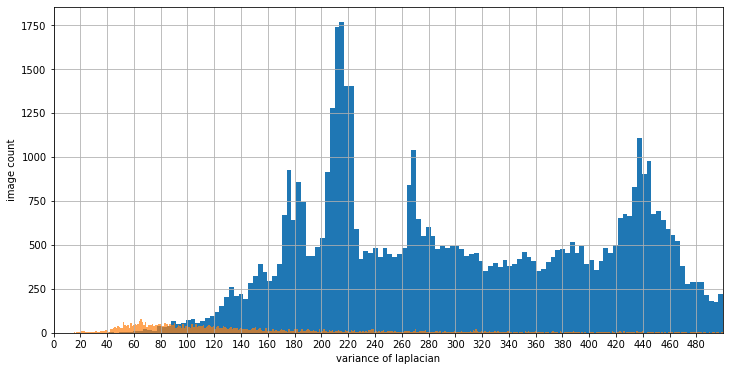

In [37]:
plt.figure(1, figsize=(12, 6))
df[df.iq_blurry == False].variance_of_laplacian.hist(bins=1000)
df[df.iq_blurry == True].variance_of_laplacian.hist(bins=1000, alpha=0.7)
plt.xticks(range(0, 500, 20))
plt.xlim(0, 500)
plt.xlabel('variance of laplacian')
plt.ylabel('image count')
plt.show()

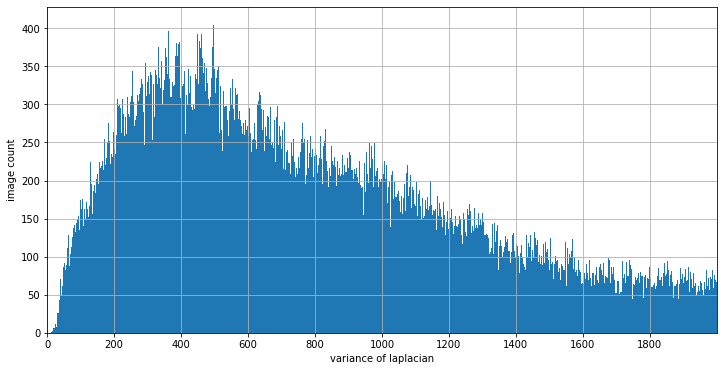

In [48]:
plt.figure(1, figsize=(12, 6))
df.variance_of_laplacian.hist(bins=10000)
plt.xticks(range(0, 2000, 200))
plt.xlim(0, 2000)
plt.xlabel('variance of laplacian')
plt.ylabel('image count')
plt.show()

In [41]:
df2[df2.id == '66315ec0d5fe5c947c205939'].unique_id, df2[df2.id == '66315ec0d5fe5c947c205939'].variance_of_laplacian

(54934    66315ec0d5fe5c947c205939_T02_T03
 54935    66315ec0d5fe5c947c205939_T02_T03
 54936    66315ec0d5fe5c947c205939_T02_T04
 54937    66315ec0d5fe5c947c205939_T02_T04
 Name: unique_id, dtype: object,
 54934    36.400127
 54935    39.025606
 54936    36.400127
 54937    39.025606
 Name: variance_of_laplacian, dtype: float64)

(394, 152)


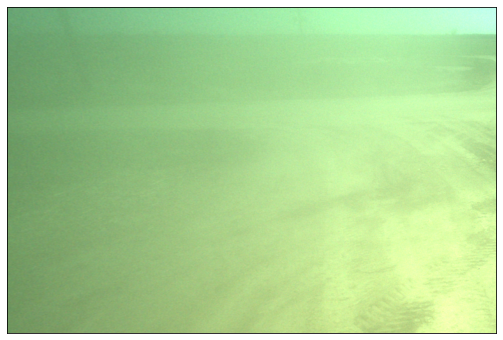

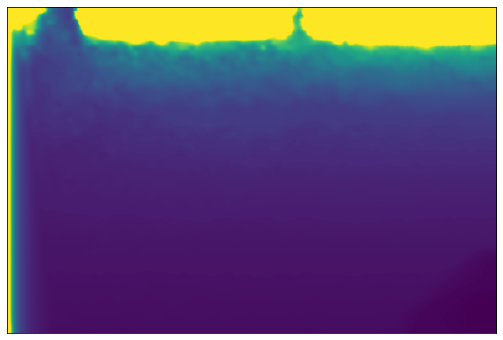

((512, 768, 3), 428037.0)

In [45]:
# check rectified image without normalization
# df2 = df[(df.iq_blurry == True) & (df.variance_of_laplacian < 80)]
print(df2.shape)
# row = df2.iloc[2]
row = df2[df2.id == '66315ec0d5fe5c947c205939'].iloc[2]
data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
data = np.load(data_path)
img = data['left']
img_norm = normalize_image(img, hdr_mode=True, return_8_bit=True)
plot_image(img_norm)
depth = data['point_cloud'][..., 2]
plot_image(depth / 100.)
img.shape, img.max()

In [14]:
depth = np.load(data_path)['point_cloud'][..., 2]
depth.shape, depth.max()

((512, 768), 100.0)

## Display images

In [33]:
# root_dir = '/data/jupiter/li.yu/data'
# root_dir = '/data/jupiter/datasets/'
root_dir = '/data2/jupiter/datasets/'
dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_stereo'
# dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_labeled'
# csv = os.path.join(root_dir, dataset, 'master_annotations_mhc.csv')
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
# converters = {}
df = pd.read_csv(csv, converters=converters)
df.shape

(9630, 136)

In [42]:
# df2 = df.merge(dust_df, on='unique_id')
# print(df2.shape)
# df3 = df2[df2.total_averaged_dust_conf > 0.2]
# print(df3.shape)
df2 = df.merge(dust_df, on='id')
print(df2.shape)
df3 = df2[df2.pred_dust_ratio > 10]
print(df3.shape)

(92847, 160)
(26, 160)


In [44]:
# df2 = df.merge(pred_df, on='unique_id')
# # df2 = df.merge(dust_df, on='unique_id')
# print(df2.shape)
# df3 = df2[df2.collected_on.str.startswith('2024-04-23T15:24:15')]
df3 = df2[df2.collected_on.str.startswith('2024-04-23T14:54:37')]
print(df3.shape)

(15, 160)


In [37]:
key_row = df[df.unique_id == '66313818fcd040489c25bbd8_T02_T04'].iloc[0]
key_row.collected_on

'2024-04-23T15:24:19.839000'

In [34]:
# df2 = df[(df.iq_blurry == True) & (df.variance_of_laplacian < 50)]
# df2 = df[(df.iq == "good") & (df.variance_of_laplacian < 30)]
# df2 = df[(df.iq != "good") & (df.iq_blurry == False)]
# df2 = df[(df.variance_of_laplacian > 50) & (df.variance_of_laplacian < 100)]
df2 = df[(df.variance_of_laplacian < 50)]
print(df2.shape, df.shape, len(df2)/len(df))

(394, 152) (92847, 152) 0.004243540448264349


66315a4224d5f28f124c420e T02 44.91199746516941


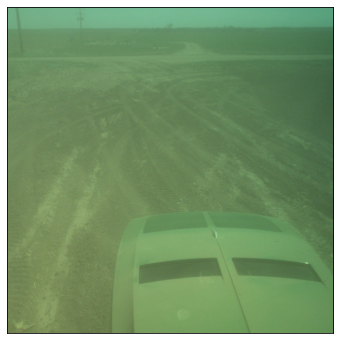

66315c7840a19993bfb11585 T02 21.441230767710497


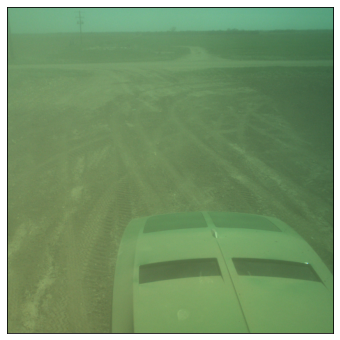

66316192769c407c7fee9bd2 T02 42.12445827660849


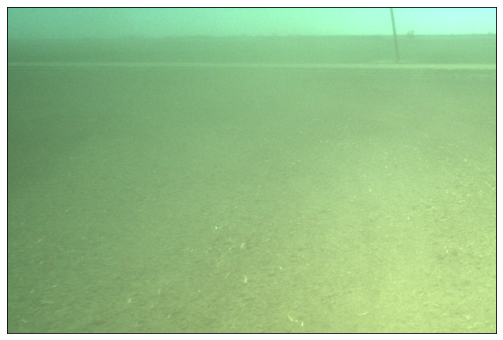

663160326bcb18102c9be745 T01 45.8885470897205


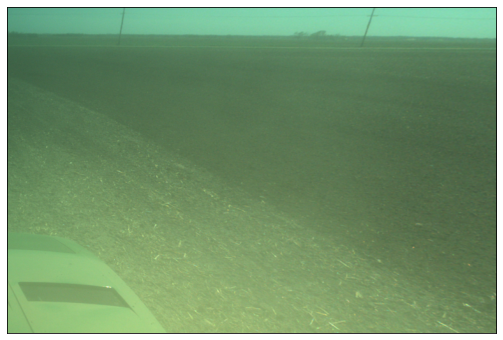

66315ec0d5fe5c947c205939 T02 36.40012667419796


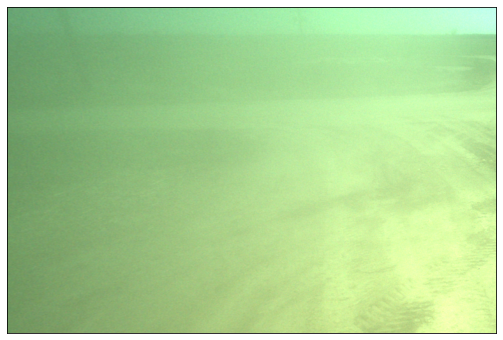

In [36]:
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['65e9b50a06198505e2a58145_T14_T15', '65e9beba4875033da619fb9b_T05_T07'])]
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
sub_df = df2.sample(5)
show_image, show_label = True, False
show_debayered_rgb, show_raw_label = False, False
show_pred_result = False

for i, row in sub_df.iterrows():
    # print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf, row.total_thresholded_dust_ratio)
    # print(row.unique_id, row.pred_dust_ratio)
    # print(row.unique_id, row.camera_location, row.collected_on, row.operation_time)
    print(row.id, row.camera_location, row.variance_of_laplacian)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, hdr_mode=True, return_8_bit=True)
        plot_image(img_norm)

    if show_debayered_rgb:
        # print(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label == 25)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label == 25)

    if show_pred_result:
        result_path = os.path.join(pred_root_dir, model, dataset, 'output_visualization', row.unique_id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))

### plot gt dust vs. pre dust

In [ ]:
df2 = df.sort_values(by='gt_dust_ratio')
gt_ratios = df2.gt_dust_ratio.to_list()
pred_ratios = df2.total_thresholded_dust_ratio.to_list()

plt.figure(1, figsize=(12, 6))
plt.plot(range(len(gt_ratios)), gt_ratios, c='b', marker=".", label='gt dust level')
plt.scatter(range(len(gt_ratios)), pred_ratios, s=15, c='r', marker="o", label='pred dust level')
plot_human_state = False
if plot_human_state:
    tp_ids, fn_ids = [], []
    for i,row in df.iterrows():
        if row.state_y == 'true_positive':
            tp_ids.append(i)
        if row.state_y == 'false_negative':
            fn_ids.append(i)
    plt.scatter(tp_ids, [0.4] * len(tp_ids), s=20, c='g', marker="o", label='pred human TP')
    plt.scatter(fn_ids, [0.6] * len(fn_ids), s=20, c='purple', marker="o", label='pred human FN')
plt.legend(loc='upper left')
plt.ylim([-0.02, 1.0])
plt.xlabel('images in ascending gt dust level order')
plt.ylabel('dust level')
plt.show()